# Stop the S@#$ - Toxic Comments EDA
https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

## Introduction
인터넷의 익명성이 때때로 사람들이 현실에서 하지 않을 험악한 말을 하게 만들 수 있습니다.

이를 걸러보도록 합시다.

## Objective
독성 코멘트 분류를 위한 EDA / 피쳐 엔지니어링 스타터 노트북

## Data Overview
데이터셋은 평가자에 의해 독성이 평가된 위키 말뭉치 데이터 세트에서 가져온 것입니다.

말뭉치는 사용자 페이지 및 2004 - 2015년 기사와 관련된 토론에서 63M개의 의견을 포함하고 있습니다.

다른 플랫폼/사이트들은 독성을 감시하는 각각의 기준들을 가지고 있습니다. 따라서 코멘트는 다음 5가지 카테고리에 태그가 지정됩니다.

- toxic (독성)
- severe_toxic (심한 독성)
- obscene (음담패설)
- threat (위협)
- insult (모욕)
- identity_hate (인종차별?)

태그 지정은 크라우드 소싱을 통해 수행되었습니다. 즉, 데이터 세트의 등급이 서로 다르며 태그 지정도 100%정확하지 않을 수 있습니다.

In [22]:
# import required packages
# basics
import pandas as pd
import numpy as np

# misc
import gc
import time
import warnings

# stats
from imageio import imread
from scipy import sparse
import scipy.stats as ss

# viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

# nlp
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# settings
start_time = time.time()
color = sns.color_palette()
sns.set_style('white')
eng_stopwords = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

%matplotlib inline

In [10]:
# Load the dataset
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [11]:
# take a peak
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [15]:
nrow_train = train.shape[0]
nrow_test = test.shape[0]
sum = nrow_train + nrow_test
print('train rows:{}, percent:{}'.format(nrow_train, round(nrow_train*100/sum)))
print('test rows:{}, percent:{}'.format(nrow_test, round(nrow_test*100/sum)))

train rows:159571, percent:51
test rows:153164, percent:49


train test 비율이 비슷합니다.

### Class Imbalance

In [16]:
x = train.iloc[:, 2:].sum()
# marking comments without any tags as 'clean'
rowsums = train.iloc[:, 2:].sum(axis=1)
train['clean'] = (rowsums==0)
# count number of clean entries
train['clean'].sum()
print('Total comments = ', len(train))
print('Total clean comments = ', train['clean'].sum())
print('Total tags = ', x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags =  35098


In [17]:
print('Check for missing values in Train dataset')
null_check = train.isnull().sum()
print(null_check)
print('Check for missing values in Test dataset')
null_check = test.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


결측치는 없습니다.

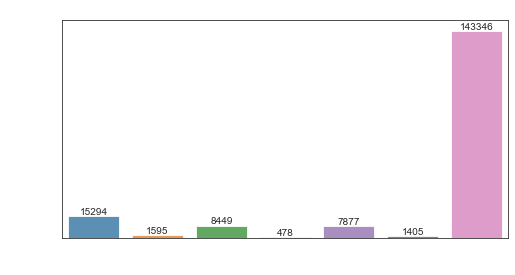

In [38]:
x = train.iloc[:, 2:].sum()
# plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('# Per Class', color='white')
plt.ylabel('# of Occurrences', fontsize=12, color='white')
plt.xlabel('Type', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')
    


In [40]:
x.values.sum()

178444

- 타입들간의 불균형 문제가 존재합니다.
- 위에서 코멘트의 수가 159571개 였는데, 그래프에 나타나는 개수는 178444개입니다.
    - 이는 하나의 코멘트가 여러 태그를 가지고 있는 (예. 한 코멘트가 독성과 음담패설을 가지고 있음) 경우를 추측해볼 수 있습니다.

### Multi-tagging
얼마나 많은 코멘트들이 다수의 태그를 가지고 있는지 확인해 보겠습니다.

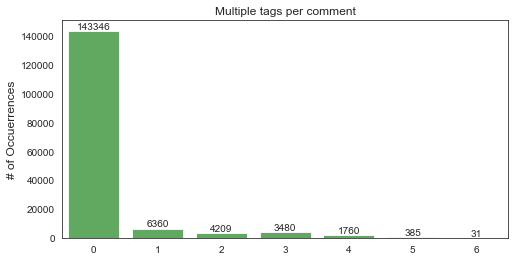

In [41]:
x = rowsums.value_counts()

# plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8, color=color[2])
plt.title('Multiple tags per comment')
plt.ylabel('# of Occuerrences', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')

In [54]:
x[2:7].sum() / x.sum()

0.06182201026502309

약 6% 정도의 코멘트가 여러 종류의 독성을 가지고 있습니다. 31개의 코멘트는 모든 종류를 다 갖고 있습니다!

## Which tags go together?
이번엔 어떤 태그들이 같이 발생하는지 알아보겠습니다. 상관관계도를 그려 확인할 수 있습니다.

<AxesSubplot:>

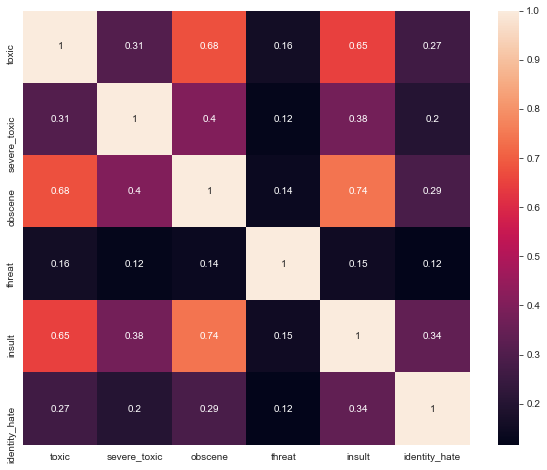

In [55]:
temp_df = train.iloc[:,2:-1]
# filter temp by removing clean comments

corr = temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)


위의 그림은 공존하는 패턴을 나타내지만 Pearson 상관 관계를 사용하는 판다스의 기분 corr 함수는 변수들이 범주형 변수이기 때문에 적용되지 않습니다.

따라서 두 범주형 변수 사이의 패턴을 찾기 위해 다음과 같은 도구를 사용할 수 있습니다.
- 혼동 매트릭스/ 크로스탭
- Cramer's V Statistics
     - 크레이머의 V 통계는 카이제곱 검정의 확장입니다. 여기서 연관성의 범위/강도도 측정됩니다.